<a href="https://colab.research.google.com/github/rishicarter/Tensorflow_fundamentals/blob/main/07_NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
# Helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, walk_through_dir

--2022-07-26 11:24:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-26 11:24:30 (59.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data('nlp_getting_started.zip')

--2022-07-26 11:24:36--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.128, 74.125.196.128, 74.125.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.009s  

2022-07-26 11:24:36 (67.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [66]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
import tensorflow_hub as hub

from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

In [4]:
# Functions
def metrics_for_classification(y_true,y_pred):
  '''
  Calculates Model accuracy, precision, recall, f1-score
  '''
  model_accuracy=accuracy_score(y_true,y_pred)
  model_precision,model_recall,model_f1,_=precision_recall_fscore_support(y_true,y_pred,
                                                                          average='weighted')
  
  model_results={'acc':model_accuracy,
                 'precision':model_precision,
                 'recall':model_recall,
                 'f1-score':model_f1}
  return model_results

# Visualise

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)

In [7]:
train_df.shape, train_df.target.value_counts()

((7613, 5), 0    4342
 1    3271
 Name: target, dtype: int64)

In [ ]:
random_index=random.randint(0, len(train_df)-5)
for row in train_df_shuffled[['text','target']][random_index:random_index+5].itertuples():
  print(f'Target: {row[2]}\nTEXT: {row[1]}\n----')

Target: 1
TEXT: Cop pulls drunk driver to safety SECONDS before his car is hit by train. http://t.co/F1BAkpNyn6åÊ http://t.co/lZXwoAyE4x via @ViralSpell
----
Target: 1
TEXT: 8/6/2015@2:09 PM: TRAFFIC ACCIDENT NO INJURY at 2781 WILLIS FOREMAN RD http://t.co/VCkIT6EDEv
----
Target: 0
TEXT: #Eyewitness media is actively embraced by #UK audiences. Read the report by @emhub on the impact of #UGC in news: http://t.co/6mBPvwiTxf
----
Target: 0
TEXT: @newyorkcity for the #international emergency medicine conference w/ Lennox Hill hospital and #drjustinmazur
----
Target: 0
TEXT: @KamKasteIIano @BluntedJayt FUCKING SCREAMING !
----


# Split data into train and validation

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                  train_df_shuffled['target'].to_numpy(),
                                                  test_size=0.1,
                                                  random_state=42)

In [9]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6851,), (762,), (6851,), (762,))

# Text Vectorization

In [10]:
from re import split
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=None,
                                    # pad_to_max_tokens=True)
)

In [ ]:
round(sum([len(i.split()) for i in X_train])/len(X_train))

15

In [11]:
max_vocab_length=10000
max_length=15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [12]:
text_vectorizer.adapt(X_train)

In [ ]:
sample='Flood in my street!'
text_vectorizer([sample])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
random_sentence = random.choice(X_train)
print(f'og text:\n{random_sentence}\n\nVect version:\n{text_vectorizer([random_sentence])}')

og text:
The Twitter update pretty much wrecked the app

Vect version:
[[   2  382  339  766  187  337    2 2194    0    0    0    0    0    0
     0]]


In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words, bottom_5_words = words_in_vocab[:5],words_in_vocab[-5:]
top_5_words,bottom_5_words

(['', '[UNK]', 'the', 'a', 'in'],
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'])

# Create an embedding layer

In [13]:
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)
embedding

In [ ]:
random_sentence = random.choice(X_train)
print(f'og text:\n{random_sentence}\n\nVect version:\n{text_vectorizer([random_sentence])}\
\n\nEmbed: \n{embedding(text_vectorizer([random_sentence]))}')

og text:
@DmoneyDemi I had my meltdown yesterday.  I'm going to miss you so much. You are forsure my DTB for life. When I get back watchout ??

Vect version:
[[   1    8   94   13  504 1730   32  104    5 1121   12   28  187   12
    22]]

Embed: 
[[[-0.02945817 -0.04263538  0.00636661 ...  0.00127202 -0.00475924
   -0.00430661]
  [-0.04265293  0.0359855  -0.03293931 ...  0.00673311 -0.04419197
   -0.0065339 ]
  [ 0.00937847 -0.01063702  0.04597089 ...  0.03837461 -0.03236707
    0.01585865]
  ...
  [ 0.0065647   0.03677611  0.03297282 ... -0.03289665  0.0470928
    0.00619414]
  [-0.02096513  0.0063977   0.01376427 ...  0.00081446  0.02607778
    0.04879594]
  [ 0.02781286  0.02420977  0.02954718 ...  0.0033896  -0.03873947
    0.03863318]]]


# Model0: Baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model_0=Pipeline([
                  ('tfidf', TfidfVectorizer()),
                   ('clf',MultinomialNB())
])
model_0.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score=model_0.score(X_val,y_val)
baseline_score

0.7926509186351706

# Model1: Dense feed forward NN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Create callback
from helper_functions import create_tensorboard_callback

SAVE_DIR = 'model_logs'

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(1, activation='sigmoid')(x)
model_1=tf.keras.Model(inputs,outputs)

model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_1.fit(X_train,y=y_train,
            validation_data=(X_val,y_val),
            epochs=5,
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                   experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20220725-152757
Epoch 1/5
215/215 [==============================] - 5s 20ms/step - loss: 0.5419 - accuracy: 0.7767 - val_loss: 0.5051 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3511 - accuracy: 0.8860 - val_loss: 0.4602 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2761 - accuracy: 0.9048 - val_loss: 0.4605 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2327 - accuracy: 0.9177 - val_loss: 0.4754 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2006 - accuracy: 0.9317 - val_loss: 0.4934 - val_accuracy: 0.7861


In [ ]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [ ]:
model_1.evaluate(X_val, y_val)

24/24 [==============================] - 0s 2ms/step - loss: 0.4934 - accuracy: 0.7861


[0.4933554232120514, 0.7860892415046692]

# Visualise learned embeddings

In [ ]:
embed_weights=model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


In [ ]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model_2: RNN - LSTM

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string')
x=text_vectorizer(inputs)
x=embedding(x)
# x=layers.LSTM(64, activation='tanh', return_sequences=True)(x)
x=layers.LSTM(64)(x)
# x=layers.GlobalAveragePooling1D()(x)
# x=layers.Dense(64,activation='relu')(x)
outputs=layers.Dense(1, activation='sigmoid')(x)
model_2=tf.keras.Model(inputs,outputs,name='model_2_LSTM')

model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [ ]:
model_2.fit(X_train, y_train, epochs=5,
            validation_steps=(X_val,y_val),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                   experiment_name='model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220725-162907
Epoch 1/5
215/215 [==============================] - 15s 50ms/step - loss: 0.1817 - accuracy: 0.9384
Epoch 2/5
215/215 [==============================] - 12s 55ms/step - loss: 0.1264 - accuracy: 0.9514
Epoch 3/5
215/215 [==============================] - 12s 54ms/step - loss: 0.1040 - accuracy: 0.9587
Epoch 4/5
215/215 [==============================] - 11s 51ms/step - loss: 0.0864 - accuracy: 0.9650
Epoch 5/5
215/215 [==============================] - 11s 52ms/step - loss: 0.0733 - accuracy: 0.9680


In [ ]:
model_2_pred_probs = model_2.predict(X_val)
model_2_pred_probs[:10]

array([[1.1300415e-02],
       [8.2869065e-01],
       [9.9953842e-01],
       [1.4635026e-02],
       [1.9729137e-04],
       [9.9574983e-01],
       [7.7439922e-01],
       [9.9969244e-01],
       [9.9974859e-01],
       [3.5617161e-01]], dtype=float32)

In [ ]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

In [ ]:
model_2_results = metrics_for_classification(y_val,model_2_preds)
model_2_results

{'acc': 0.7769028871391076,
 'f1-score': 0.7743498017353971,
 'precision': 0.7798819103655997,
 'recall': 0.7769028871391076}

# Model_3: GRU or Gated Recurrent Unit

In [35]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
# x=layers.GRU(64, return_sequences=True)(x)
# x=layers.LSTM(64)(x)
x=layers.GRU(32)(x)
# x=layers.Dense(8, activation='relu')(x)
outputs=layers.Dense(1, activation='sigmoid')(x)
model_3=tf.keras.Model(inputs,outputs)

model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_3.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru_8 (GRU)                 (None, 32)                15552     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,295,585
Trainable params: 1,295,585
Non-trainable params: 0
_________________________________________________

In [36]:
hist_3=model_3.fit(X_train,y_train,
                   epochs=5, validation_data=(X_val,y_val))

Epoch 1/5
215/215 [==============================] - 11s 36ms/step - loss: 0.2329 - accuracy: 0.8910 - val_loss: 0.7294 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0740 - accuracy: 0.9743 - val_loss: 0.8125 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0553 - accuracy: 0.9771 - val_loss: 0.9207 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0457 - accuracy: 0.9794 - val_loss: 1.0791 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0392 - accuracy: 0.9809 - val_loss: 1.1896 - val_accuracy: 0.7664


In [37]:
model_3_pred_probs= model_3.predict(X_val)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

In [38]:
model_3_results=metrics_for_classification(y_val,model_3_preds)

In [39]:
model_3_results

{'acc': 0.7664041994750657,
 'f1-score': 0.7657033077547232,
 'precision': 0.7660697359722247,
 'recall': 0.7664041994750657}

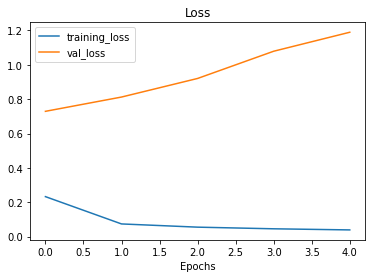

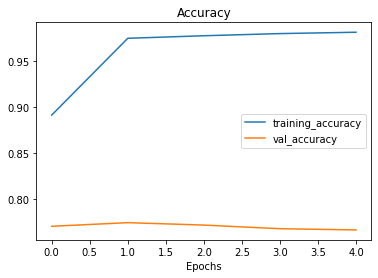

In [40]:
plot_loss_curves(hist_3)

# Model_4: Bidirectional LSTM

In [47]:
from tensorflow.keras import layers

inputs=layers.Input(shape=(1,), dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x=layers.Bidirectional(layers.GRU(32))(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
model_4=tf.keras.Model(inputs,outputs)

model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_4.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 15, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                           

In [55]:
hist_4=model_4.fit(X_train,y_train, epochs=5,
            validation_data=(X_val,y_val))

Epoch 1/5
215/215 [==============================] - 20s 94ms/step - loss: 0.0454 - accuracy: 0.9794 - val_loss: 1.1118 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 12s 54ms/step - loss: 0.0385 - accuracy: 0.9799 - val_loss: 1.2460 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 11s 53ms/step - loss: 0.0352 - accuracy: 0.9810 - val_loss: 1.5967 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 11s 53ms/step - loss: 0.0322 - accuracy: 0.9829 - val_loss: 1.6771 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 11s 52ms/step - loss: 0.0321 - accuracy: 0.9835 - val_loss: 1.7557 - val_accuracy: 0.7480


In [56]:
model_4_pred_probs = model_4.predict(X_val)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results=metrics_for_classification(y_val,model_4_preds)

In [57]:
model_4_results

{'acc': 0.7480314960629921,
 'f1-score': 0.7476983829605197,
 'precision': 0.7476243671645544,
 'recall': 0.7480314960629921}

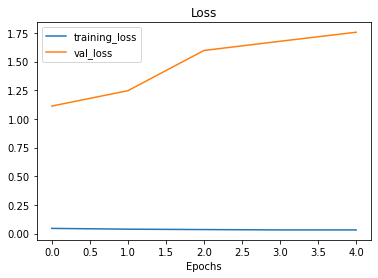

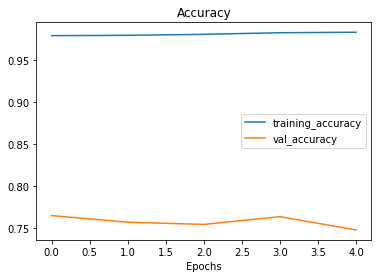

In [58]:
plot_loss_curves(hist_4)

# Model_5: 1D CNN

In [60]:
inputs=layers.Input(shape=(1,), dtype='string')
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.Conv1D(64,kernel_size=5,activation='relu',padding='valid')(x)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(1, activation='sigmoid')(x)
model_5=tf.keras.Model(inputs,outputs)

model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [61]:
model_5.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_13 (Dense)            (None, 1)                 65  

In [62]:
hist_5=model_5.fit(X_train,y_train,
                   validation_data=(X_val,y_val),
                   epochs=5)

Epoch 1/5
215/215 [==============================] - 8s 30ms/step - loss: 0.1248 - accuracy: 0.9603 - val_loss: 0.8921 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0659 - accuracy: 0.9758 - val_loss: 1.0205 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0532 - accuracy: 0.9803 - val_loss: 1.1294 - val_accuracy: 0.7467
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0481 - accuracy: 0.9816 - val_loss: 1.1996 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0491 - accuracy: 0.9809 - val_loss: 1.1460 - val_accuracy: 0.7402


In [63]:
model_5_pred_probs=model_5.predict(X_val)
model_5_pred=tf.squeeze(tf.round(model_5_pred_probs))
model_5_results=metrics_for_classification(y_val,model_5_pred)
model_5_results

{'acc': 0.7401574803149606,
 'f1-score': 0.7405706930170428,
 'precision': 0.7420028169895228,
 'recall': 0.7401574803149606}

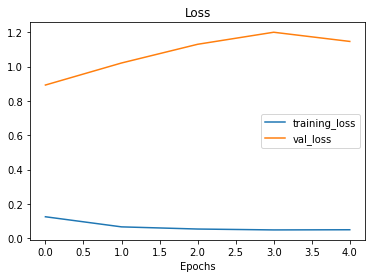

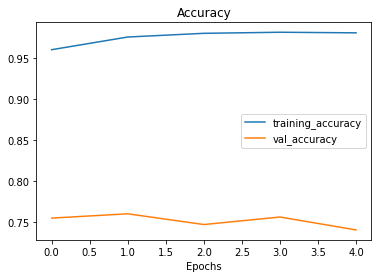

In [64]:
plot_loss_curves(hist_5)

# Model_6: Trnansfer learning

In [67]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,trainable=False,
                                        name='USE')

In [73]:
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64,activation='relu'),
  layers.Dense(1, activation='sigmoid')
], name='model_6_USE')

model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_15 (Dense)            (None, 64)                32832     
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [74]:
hist_6=model_6.fit(X_train,y_train,
                   epochs=5,
                   validation_data=(X_val,y_val))

Epoch 1/5
215/215 [==============================] - 7s 25ms/step - loss: 0.4982 - accuracy: 0.7895 - val_loss: 0.4737 - val_accuracy: 0.7927
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4147 - accuracy: 0.8154 - val_loss: 0.4410 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4012 - accuracy: 0.8192 - val_loss: 0.4393 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3926 - accuracy: 0.8253 - val_loss: 0.4326 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3853 - accuracy: 0.8310 - val_loss: 0.4294 - val_accuracy: 0.8110


In [75]:
model_6_pred_probs=model_6.predict(X_val)
model_6_pred=tf.squeeze(tf.round(model_6_pred_probs))
model_6_results=metrics_for_classification(y_val,model_6_pred)
model_6_results

{'acc': 0.8110236220472441,
 'f1-score': 0.809712990337905,
 'precision': 0.8125376224203776,
 'recall': 0.8110236220472441}

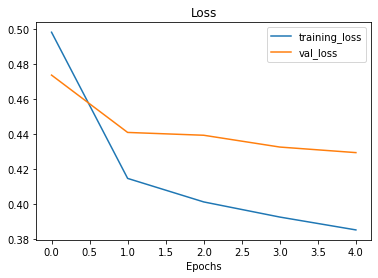

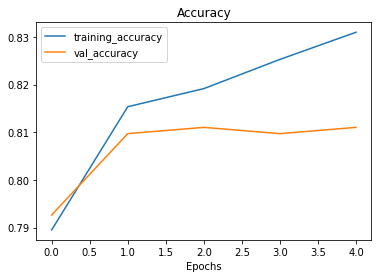

In [77]:
plot_loss_curves(hist_6)

# Model_7: transfer learning with 10% data

In [78]:
train_10p = train_df_shuffled[['text','target']].sample(frac=0.1,random_state=42)
train_sentences_10p=train_10p['text'].to_list()
train_labels_10p=train_10p['target'].to_list()

In [79]:
train_10p['target'].value_counts()

0    413
1    348
Name: target, dtype: int64

In [82]:
model_7 = tf.keras.models.clone_model(model_6)
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_15 (Dense)            (None, 64)                32832     
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [92]:
hist_7=model_7.fit(X_train[:int(0.1*len(X_train))],y_train[:int(0.1*len(X_train))],
    # train_sentences_10p,train_labels_10p,
                   epochs=5,
                   validation_data=(X_val,y_val))

Epoch 1/5
22/22 [==============================] - 1s 31ms/step - loss: 0.3501 - accuracy: 0.8540 - val_loss: 0.4202 - val_accuracy: 0.8241
Epoch 2/5
22/22 [==============================] - 0s 23ms/step - loss: 0.3362 - accuracy: 0.8642 - val_loss: 0.4278 - val_accuracy: 0.8136
Epoch 3/5
22/22 [==============================] - 1s 23ms/step - loss: 0.3235 - accuracy: 0.8701 - val_loss: 0.4340 - val_accuracy: 0.7966
Epoch 4/5
22/22 [==============================] - 0s 23ms/step - loss: 0.3123 - accuracy: 0.8686 - val_loss: 0.4412 - val_accuracy: 0.7992
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.3021 - accuracy: 0.8832 - val_loss: 0.4506 - val_accuracy: 0.7913


In [93]:
model_7_pred_probs=model_7.predict(X_val)
model_7_pred=tf.squeeze(tf.round(model_7_pred_probs))
model_7_results=metrics_for_classification(y_val,model_7_pred)
model_7_results

{'acc': 0.7913385826771654,
 'f1-score': 0.7893870954882566,
 'precision': 0.7936442238217675,
 'recall': 0.7913385826771654}

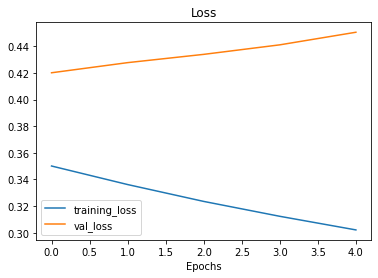

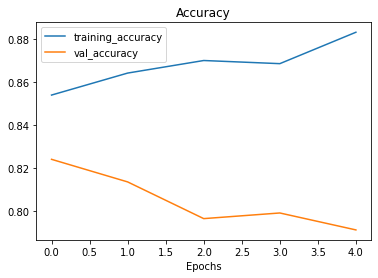

In [94]:
plot_loss_curves(hist_7)

# Save model

In [ ]:
# model_6.save('model_6.h5')

In [ ]:
# # loaded_model=tf.keras.models.load_model('model_6.h5',
#                                         custom_object={'KerasLayer':hub.KerasLayer})

# Model Evaluation

In [95]:
val_df = pd.DataFrame({'text':X_val,
                       'target':y_val,
                       'pred':model_6_pred,
                       'pred_prob':tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.175519
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.813867
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988501
3,@camilacabello97 Internally and externally scr...,1,0.0,0.231943
4,Radiation emergency #preparedness starts with ...,1,1.0,0.744175


In [96]:
most_wrong=val_df[val_df['target']!=val_df['pred']].sort_values('pred_prob',ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.923386
759,FedEx will no longer transport bioterror patho...,0,1.0,0.904221
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.881813
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.869407
628,@noah_anyname That's where the concentration c...,0,1.0,0.866511
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.846718
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.813867
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.800255
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.797495
144,The Sound of Arson,0,1.0,0.781728


# Predictions on test dataset

In [97]:
test_pred_prob = model_6.predict(test_df['text'].to_list())
test_pred=tf.squeeze(tf.round(test_pred_prob))

# Speed/score tradeoff

In [103]:
import time
def pred_timer(model, samples):
  start_time = time.perf_counter()
  model.predict(samples)
  end_time=time.perf_counter()
  total_time=end_time-start_time
  time_per_pred=total_time/len(samples)

  return total_time,time_per_pred